# 10.1 확률적 경사하강법이란?

지금까지는 파라미터 업데이트를 하기 위해 데이터셋의 모든 샘플들을 모델에 통과 시킨 후 손실 값을 계산했다.  
그리고 손실 값을 가중치 파라미터들로 미분하여 파라미터를 업데이트 할 수 있었다.

<img src = "확률적1.jpg" width = "400" height = "400">

하지만 이런 방법은 몇가지 문제가 있다.  
* GPU 메모리는 한계가 있기 때문에 큰 데이터셋을 한 번에 계산하는 것이 어려울 수 있음.
* 학습 속도에 문제가 생길 수 있음.  

한번의 파라미터 업데이트를 위해서 전체 데이터를 모델에 통과시키는 계산은 비효율적이라는 판단이다.  
이때 확률적 경사하강법(SGD)를 통해 문제를 해결한다.  

SGD는 랜덤 샘플링한 k개의 샘플을 모델에 통과시켜 손실 값을 계산하고, 미분 이후에 파라미터 업데이트를 수행한다.  
이때 샘플링 과정에서 주의할 점은 "비복원 추출을 수행"하는 것이다.  

이런 샘플링을 하는 과정이 확률적으로 동작하고, 랜덤 샘플링된 k개의 샘플들의 묶음을 미니배치 라고 부른다.

<img src = "확률적2.jpg" width = "400" height = "400">
<img src = "확률적3.jpg" width = "400" height = "400">

샘플링 과정이 비복원 추출이기 때문에 모델을 통과하지 않은 샘플이 더 이상 없을 때 까지 기존에 모델을 통과한 샘플들은 사용되지 않는 것이다.  
이렇게 전체 데이터셋의 샘플들이 전부 모델을 통과하는 것을 한번의 에포크 라고 부르며, 한 개의 미니배치를 모델에 통과시키는 것을 이터레이션 이라고 한다.  

미니배치의 크기가 작아질수록 파라미터 업데이트 횟수가 늘어난다.  
SGD를 구현하기 위해서는 자연스럽게 for-loop가 만들어질 수밖에 없다. (바깥쪽 for-loop는 에포크, 안쪽은 이터레이션)

# 10.2 SGD의 직관적 이해

<img src = "확률적4.jpg" width = "400" height = "400">

검은색 화살표 점선 : 경사하강법을 나타낸 것  
빨간색 화살표 : 확률적 경사하강법으로 얻을 수 있는 그래디언트 방향과 크기

빨간색 화살표 점선이 중구난방으로 위치한 것과 같이 비효율적인 최적화를 수행하는 것처럼 보일 수 있지만, 굉장히 극소수 샘플들을 통해 얻을 수 있는 것이므로 꼭 비효율적이라고 보기는 어렵다.  
오히려 현실의 손실 표면은 이에 비해 훨씬 지저분하게 구성되어 있을 수 있기 때문에 검은색 점선도 삐뚤빼뚤하게 위치할 수 있다.  
또한 빨간색 화살표 점선이 GD기준의 지역최소점을 무시하고 빠져나올 가능성도 있다.

결론: 미니배치가 커질수록 그래디언트는 실제 그래디언트와 비슷해질 확률이 높아지고, 매니배치가 작아질수록 그래디언트는 실제 그래디언트와 달라질 확률이 높아진다.

# 10.3 미니배치 크기에 따른 SGD

미니배치의 크기도 중요한 하이퍼파라미터중 하나이다. 보통 256정도 크기에서 시작하는 것이 좋다.

### 1. 미니배치 크기에 따른 파라미터 업데이트 횟수

이터레이션이 많을수록 신경망은 학습활 기회가 많아진다.  
미니배치 크기를 줄여서 이터레이션 숫자를 마냥 늘리기만 하면, 그래디언트에 노이즈가 생길 수 있다.  
반대로 미니배치 크기를 늘려서 이터레이션 숫자를 줄이면 그래디언트 방향은 좀 더 정확해질 수도 있다.  
이터레이션 횟수를 줄이되 학습률을 크게 잡아 파라미터가 업데이트 되는 양을 늘릴 수도 있다.

# 10.4 SGD 적용하기

### 1. 데이터 준비

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

이번 실습에서는 집에 대한 정보들이 주어졌을 때 평균 집값을 나타내는 Target칼럼을 맞춰본다.

In [3]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


데이터의 분포를 파악하기 위해서 1000개만 임의 추출하여 페어플롯 그려보기

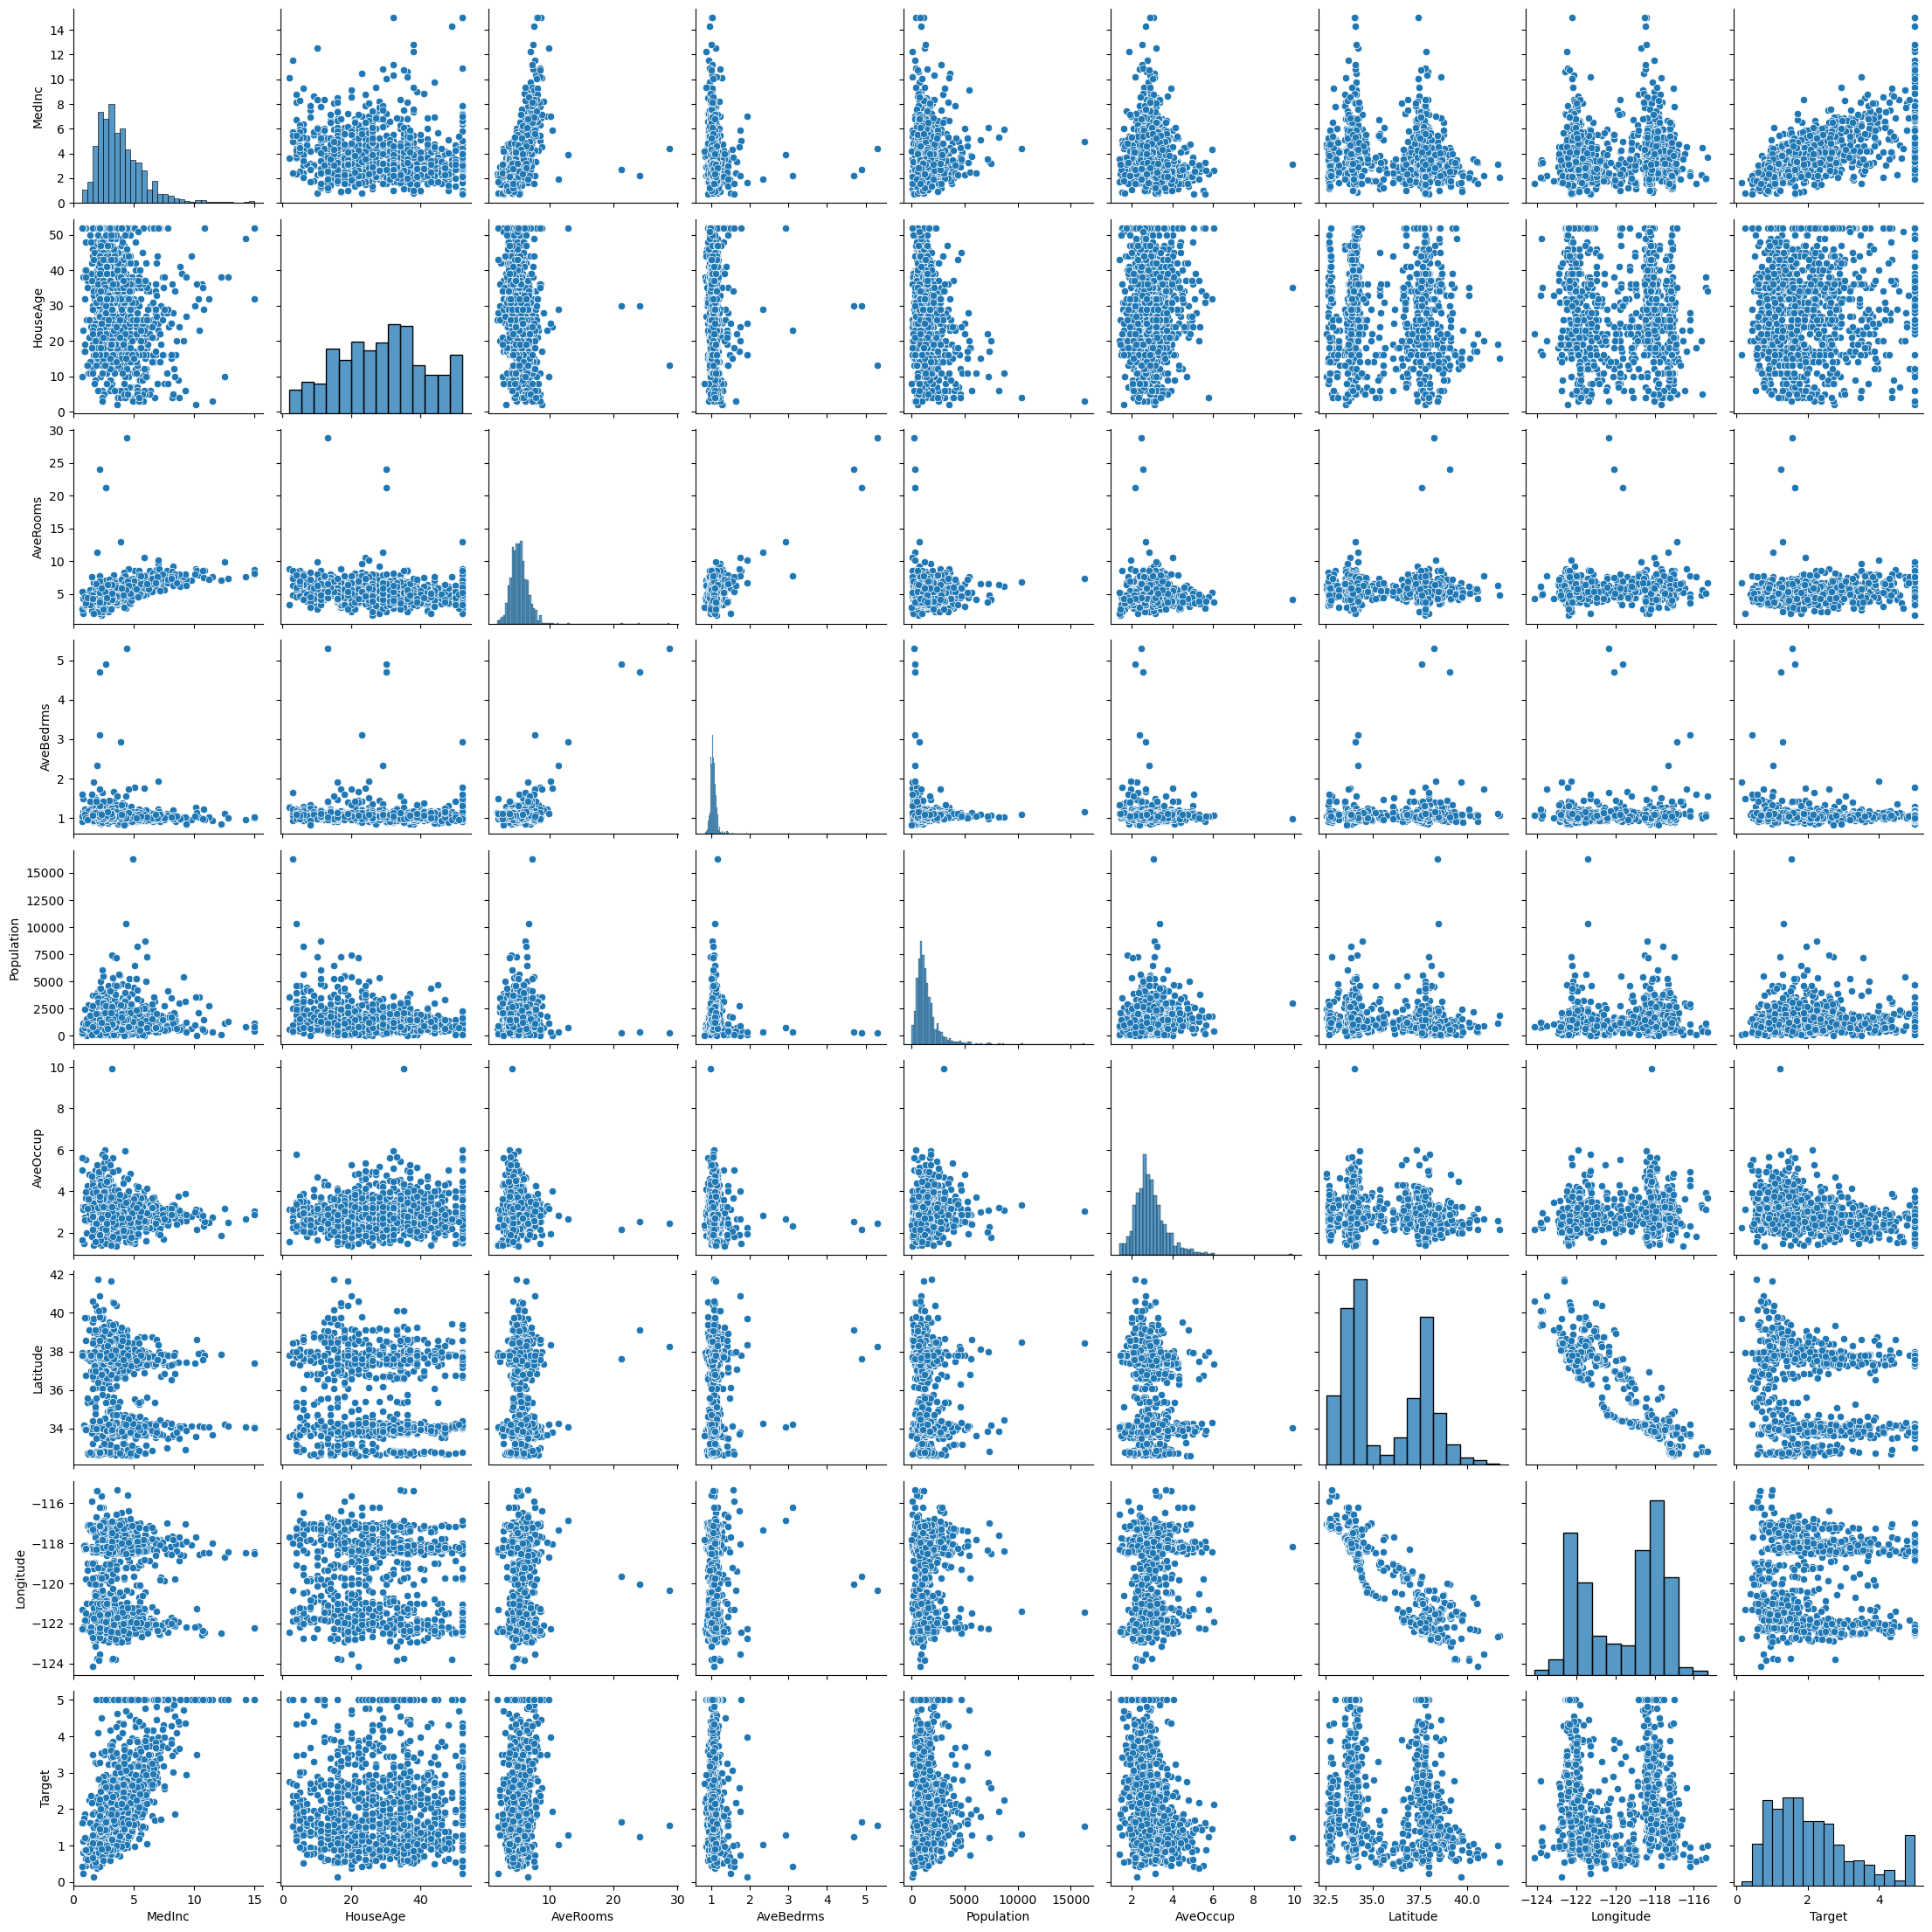

In [4]:
sns.pairplot(df.sample(1000))
plt.show()

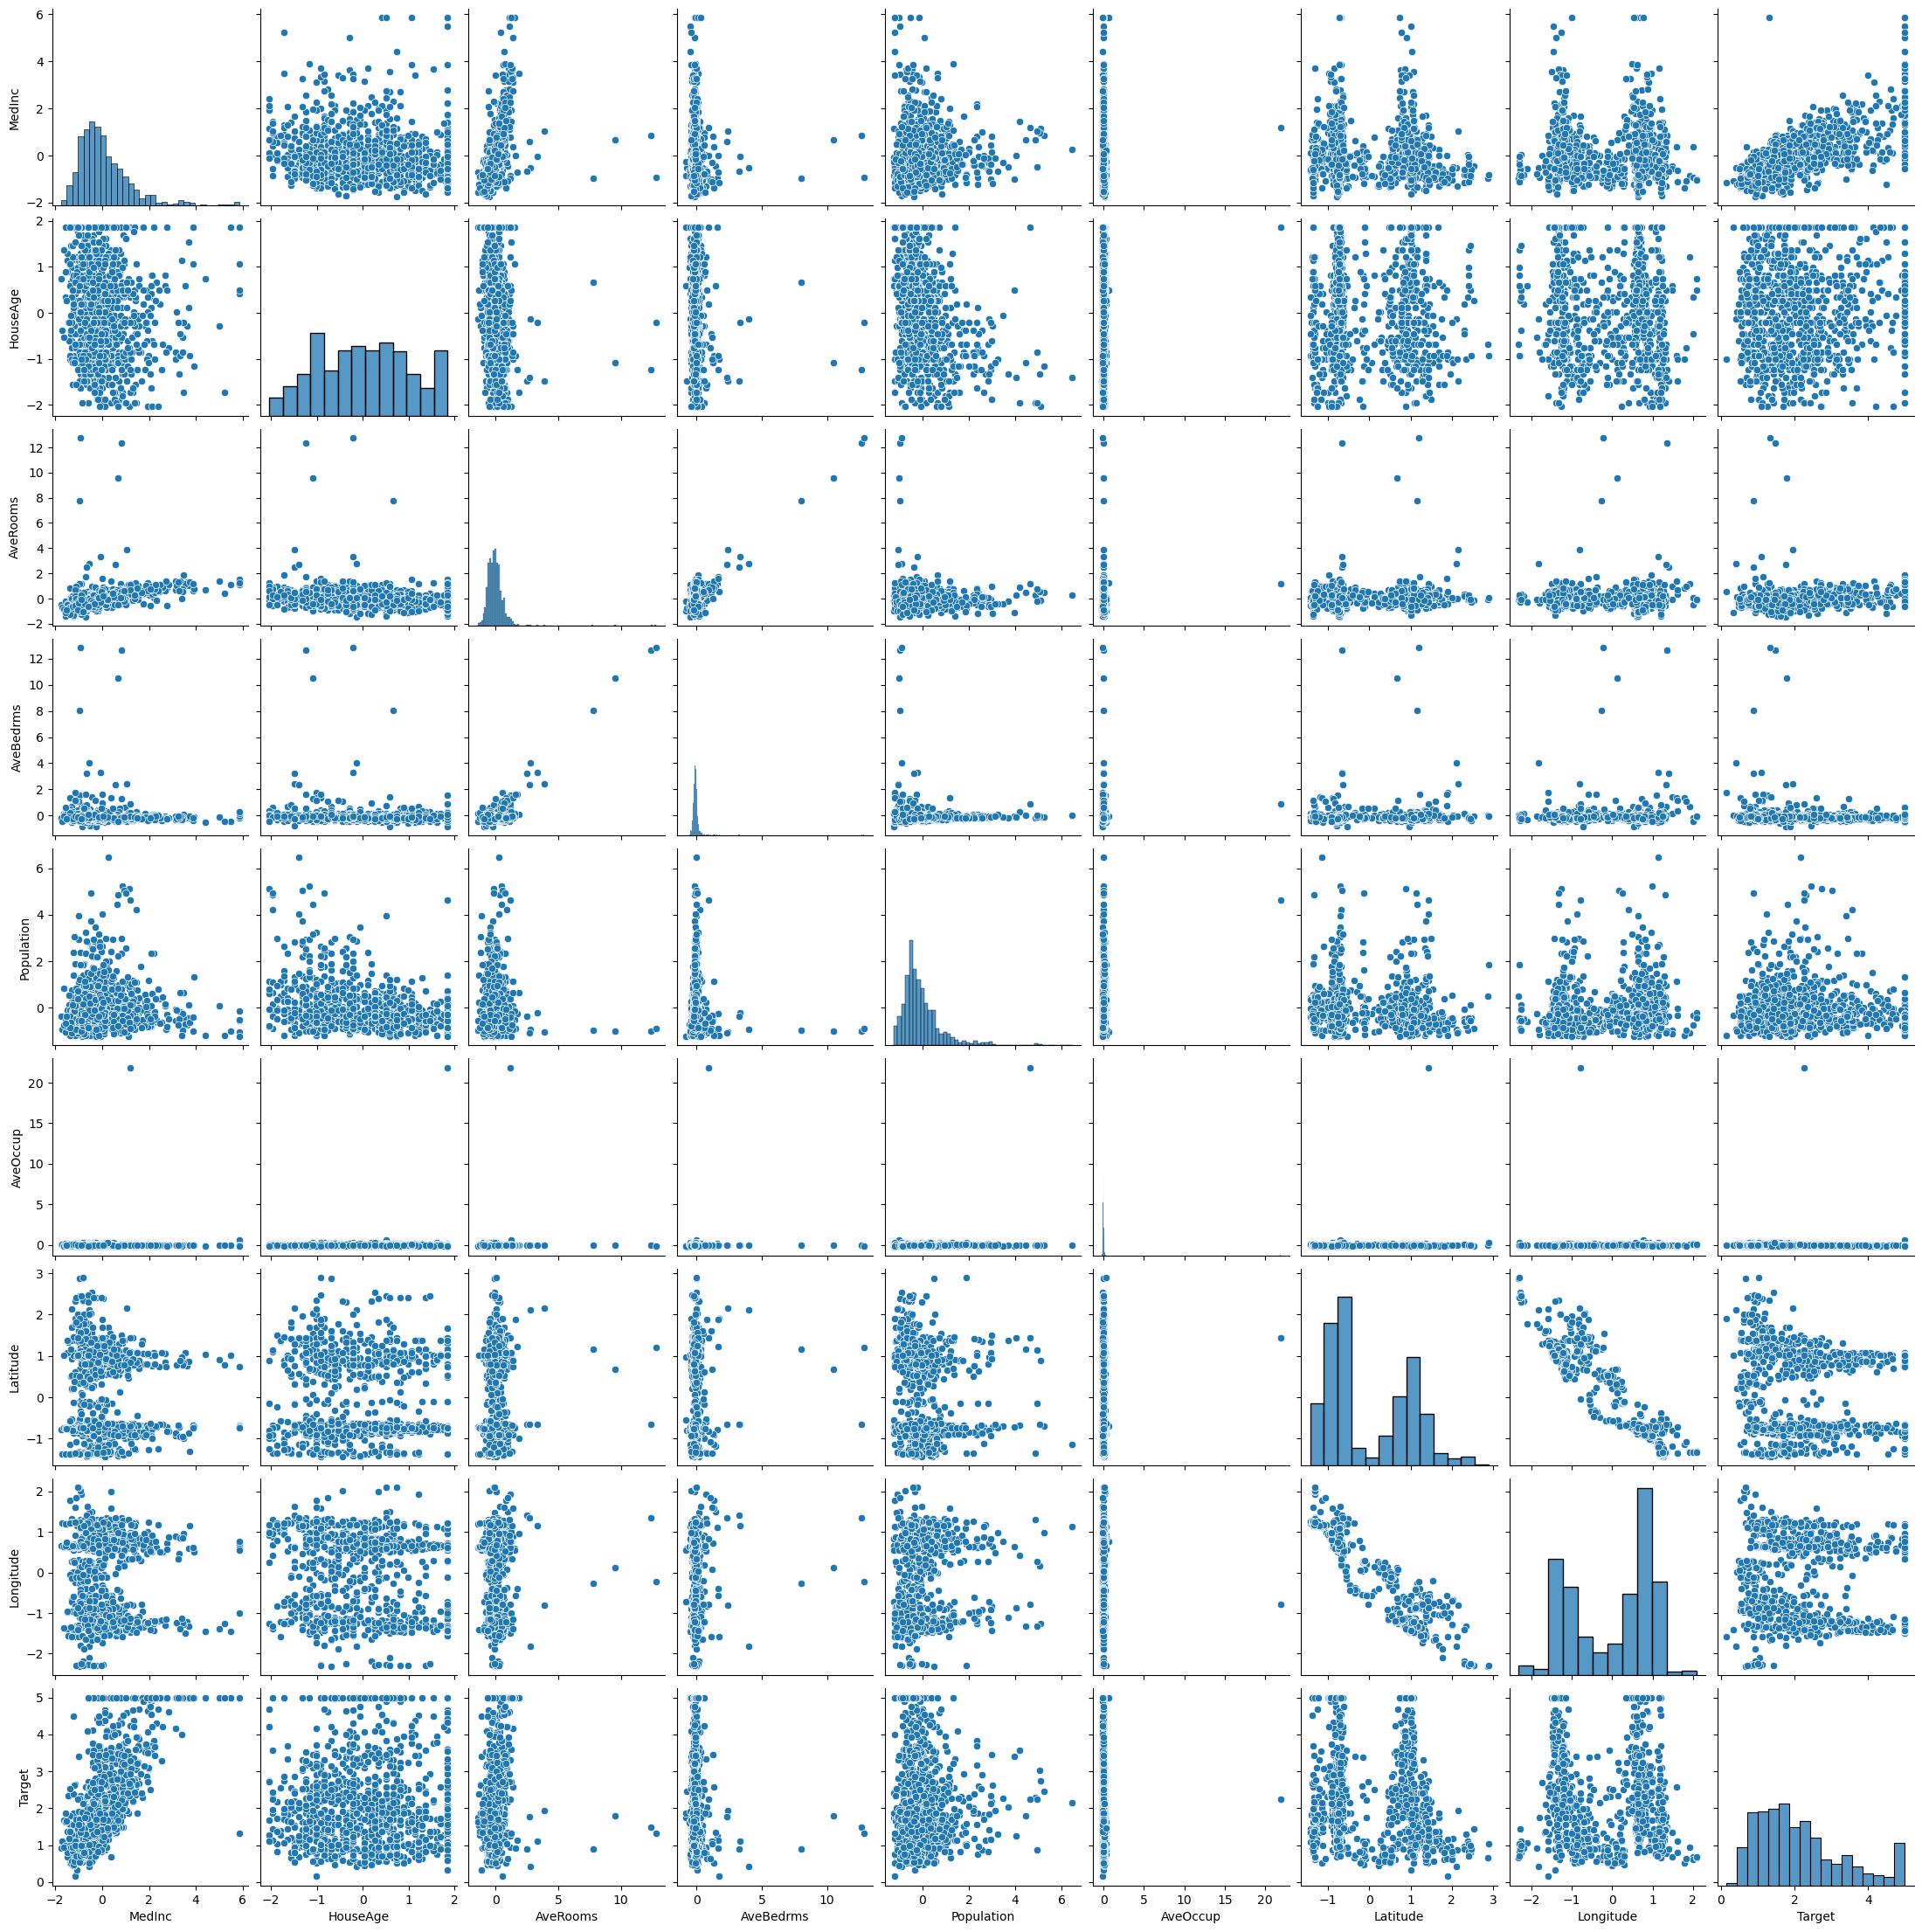

In [7]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

sns.pairplot(df.sample(1000))
plt.show()

scaler = StandardScaler() : 데이터를 표준화 (평균이0, 표준편차가1)가 되도록 데이터를 반환한다.  
scaler.fit(df.values[:, :-1]) : StandardScaler의 개체를 DataFrame에 맞춘다. 나중에 데이터를 변환하는 데 사용되는 DataFrame의 각 feature에 대한 평균 및 표준 편차를 계산합니다.  
df.values[:, :-1] = scaler.transform(df.values[:, :-1]) : 적합한 StandardSclaer를 사용하여 df의 기능값을 반환한다. transform 방법은 각 특성에 대한 평균을 빼고 표준편차로 나누어 데이터를 표준화 한다. 변환된 데이터는 다시 DataFrame에 할당된다.  
sns.pairplot(df.sample(1000)): seaborn을 사용하여 쌍별 플롯을 생성합니다. (sns.pairplot()) 표준화된 DataFrame df용. sample(1000) 메서드는 DataFrame에서 무작위로 1000개의 행을 선택하여 오버플로팅을 방지하고 플롯의 성능을 향상시키는 데 사용됩니다

### 2. 학습 코드 구현

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

앞에서 정제된 데이터를 파이토치 텐서로 변환하고 그 크기를 확인한다.

In [9]:
data = torch.from_numpy(df.values).float()

print(data.shape)

torch.Size([20640, 9])


입력데이터와 출력 데이터를 분리하여 각각 x와 y에 저장한다.

In [10]:
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


학습에 필요한 세틱 값을 지정한다. 모델은 전체 데이터셋의 모든 샘플을 최대 4천번 학습할 것이다.  
배치사이즈는 256으로 지정하고 학습률은 0.01로 한다.

In [11]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

nn.Sequential 클래스를 활용하여 심층신경망을 구성한다.  
nn.Sequential을 선언할 때, 선형 계층 nn.Linear와 활성함수 nn.LeakyReLU를 선언하여 넣어준다.  
주의할 점은 첫 번째 선형 계층과 마지막 선형 계층은 실제 데이터셋 텐서 x의 크기(8)과 y의 크기(1)를 입출력 크기로 갖도록 정해주었다는 것이다.  
내부의 선형 계층들은 서로 입출력 크기가 호환되도록 되어있다는 점도 주목해야한다.

In [16]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


그러나 한 가지 가능한 이유는 입력 데이터에 원-핫 인코딩된 범주형 기능이 포함되어 있기 때문일 수 있습니다. 원-핫 인코딩에서 k 범주가 있는 범주형 기능은 k개의 이진 기능으로 변환되며 각 기능은 서로 다른 범주를 나타냅니다.

하나의 -핫 인코딩은 범주형 기능에 적용되며 이진 기능 중 하나는 일반적으로 "더미 변수 트랩"을 피하기 위해 삭제됩니다. 더미 변수 트랩은 이진 기능 중 하나가 다른 기능에서 완벽하게 예측될 수 있을 때 발생합니다. 바이너리 기능 중 하나를 삭제하면 이 문제를 방지하고 입력 데이터가 선형적으로 독립적인 기능을 갖도록 할 수 있습니다.

바이너리 기능 중 하나가 원-핫 인코딩 프로세스에서 삭제된 경우 입력 데이터에는 원래 범주형 기능보다 하나 적은 기능이 있습니다. 이는 보고 있는 코드에서 선형 레이어 입력이 1 감소한 이유를 설명할 수 있습니다. 선형 레이어 입력 크기는 원-핫 인코딩 단계 후 입력 데이터의 기능 수와 일치하도록 조정됩니다.

앞에서 생성한 모델 객체의 파라미터를 학습시킬 옵티마이저를 생성한다.

In [17]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for 반복문을 두개를 돌려서 바깥쪽 for 반복문은 정해진 최대 에포크 수만큼 반복을 수행하여, 모델이 데이터셋을 n_epochs 만큼 반복해서 학습을 수행할 수 있도록 한다.  
안쪽 for 반복문은 미니배치에 대해서 피드포워딩과 역전파 그리고 경사하강을 수행한다.  
따라서 안쪽 for 반복문 앞을 보면 매 에포크마다 데이터셋을 랜덤하게 섞어주고 미니배치로 나누는 것을 볼 수 있다.

randperm 함수를 통해서 새롭게 섞어줄 데이터셋의 인덱스 순서를 정한다.  
index_select함수를 통해서 새롭게 섞어줄 데이터셋의 인덱스 순서대로 데이터셋을 섞어준다.  
마지막으로 split 함수를 활용하여 원하는 배치사이즈로 텐서를 나눠주면 미니배치를 만드는 작업이 끝난다.  

y_hat이라는 빈 리스트를 만들어 미니배치마다 y_hat_i 변수에 피드포워딩 결과가 나오면 y_hat에 차례대로 저장한다.  
마지막 에포크가 끝나면 y_hat 리스트를 파이토치 cat 함수를 활용하여 이어 붙여 하나의 텐서로 만든 후에 실제 정답과 비교한다.

In [19]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_,y_):
        # |x_i| = |x_[i]|
        # |y_i| = y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total_loss += float(loss) # This is very important to prevent memory leak.
        
        y_hat += [y_hat_i]
        
        
    total_loss = total_loss / len(x_)
    if(i + 1) % print_interval == 0:
        print("Epoch %d: loss=%.4e" % (i + 1, total_loss))
        
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)
# |y_hat| = (total_size, output_dim)
# |y| = (total_size, output_dim)

Epoch 200: loss=3.1599e-01
Epoch 400: loss=3.1245e-01
Epoch 600: loss=3.0816e-01
Epoch 800: loss=3.0573e-01
Epoch 1000: loss=3.0325e-01
Epoch 1200: loss=3.0310e-01
Epoch 1400: loss=3.0238e-01
Epoch 1600: loss=2.9896e-01
Epoch 1800: loss=2.9567e-01
Epoch 2000: loss=2.9342e-01
Epoch 2200: loss=2.9185e-01
Epoch 2400: loss=2.9125e-01
Epoch 2600: loss=2.9080e-01
Epoch 2800: loss=2.9083e-01
Epoch 3000: loss=2.9050e-01
Epoch 3200: loss=2.9008e-01
Epoch 3400: loss=2.9036e-01
Epoch 3600: loss=2.8989e-01
Epoch 3800: loss=2.8969e-01
Epoch 4000: loss=2.8971e-01


앞의 코드에서 loss 변수에 담긴 손실 값 텐설르 float 타입캐스팅을 통해 단순 float탕입으로 변환하여 train_loss 변수에 더하는 것을 볼 수 있다.  
타입캐스팅 이전의 loss 변수는 파이토치 텐서 타입으로 그래디언트를 가지고 있고, 파이토치의 AutoGrad작동 원리에 의해서 loss 변수가 계산될 때 까지 활용된 파이토치 텐서 변수들이 줄줄이 엮여있다.  
따라서 float 타입캐스팅이 없다면 total_loss도 파이토치 텐서가 될 것이고, total_loss 변수는 해당 에포크의 모든 loss변수를 엮고 있을 것이다.  
결과적으로 total_loss가 메모리에서 없어지지 안흔다면 loss 변수와 그에 엮인 텐서 변수들 모두 아직 참조 중인 상태이므로 메모리 누수가 발생하게 된다.  
그러므로 앞과 같은 상황에서는 float 타입캐스팅 또는 detach 함수를 통해 AutoGrad를 하기 위해 연결된 그래프를 잘라내는 작업이 필요하다.

### 3. 결과 확인

페어 플롯을 통해 확인 해보면 조금 넓게 퍼져있긴 하지만 대체로 중앙을 통과하는 대각선 주변에 점들이 분포하는 것을 확인할 수 있다.

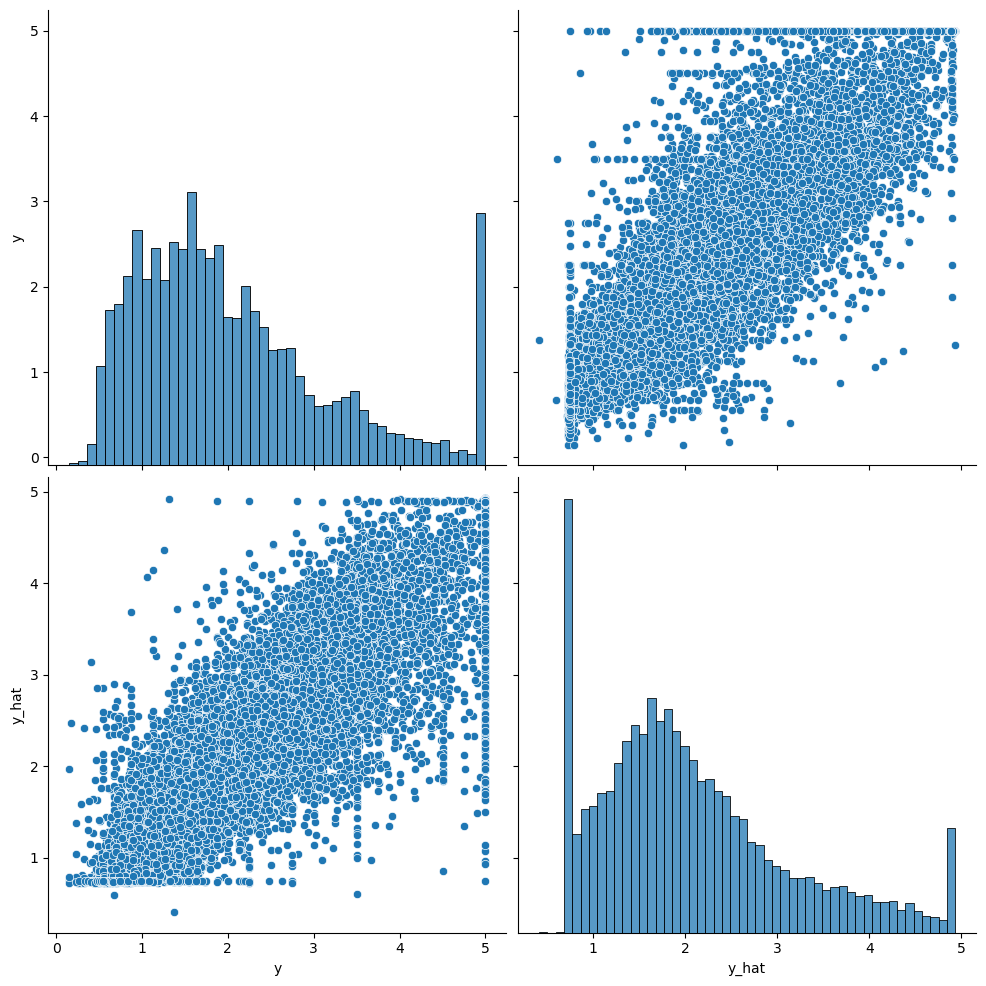

In [21]:
df = pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()

코드는 두 번째 차원(dim=1)을 따라 텐서 y 및 y_hat를 연결하기 위해 PyTorch 라이브러리를 사용하는 것으로 보입니다. 결과 텐서를 numpy 배열로 변환한 다음 numpy 배열로 Pandas DataFrame을 생성합니다.

y 및 y_hat이 다음과 같은 PyTorch 텐서라고 가정합니다. 행 수가 같으면 결과로 연결된 텐서의 행 수와 열 수는 동일합니다. 첫 번째 열은 텐서 y에 해당하고 두 번째 열은 텐서 y_hat에 해당합니다. .detach() 메서드는 계산 그래프에서 텐서를 분리하여 연결 작업 중에 그래디언트 정보 추적을 방지하는 데 사용됩니다.

결과로 생성된 numpy 배열을 사용하여 "y" 및 "y_hat"이라는 두 개의 열이 있는 Pandas DataFrame. DataFrame은 입력 텐서와 동일한 수의 행을 가지며 추가 분석 또는 시각화에 사용할 수 있습니다

# 10.5 마치며

확률적 경사하강법은 단일 반복에서 기울기를 구할 때 사용되는 데이터이가 1개 이므로 노이즈가 심하다는 단점이 있다.  
따라서 미니배치의 크기 설정을 통해 이러한 단점을 줄이는 방법에 대해서도 배웠다.  
이 밖에도 확률적 경사하강법을 변형시킨 여러 알고리즘이 존재한다.

## 요약

### SGD
* SGD는 비복원 추출을 통해 일부 샘플을 뽑아 미니배치를 구성하고 피드포워딩 및 파라미터 업데이트를 수행하는 방법
* 기존 전체 데이터셋을 활용하는 방식에 비해 파라미터 업데이트를 효율적으로 수행할 수 있음

### 용어설명
* 에포크 : 모델이 데이터 전체를 학습하는 것
* 이터레이션 : 모델의 파라미터 업데이트를 1회 수행하는 것

### 미니배치 크기에 따른 특징
* 미니배치가 작을수록 한 에포크 내에서 파라미터를 업데이트 하는 횟수가 증가
* 미니배치가 클수록 그래디언트에 노이즈가 줄어듦
* 메모리가 허용하는 한에서 큰 미니배치를 사용하면 좋음
* 미니배치 크기는 2의n제곱 형태로 정해주는 것이 속도에 유리함

### 데이터 크기와 미니배치 크기에 따른 이터레이션 횟수 계산 수식
<img src = "확률적5.jpg" width = "400" height = "400">